In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime, time, timedelta
from IPython.display import HTML, Image, display
import re

### **FILE LOG HASIL OBSERVASI (DALAM CSV)**

Tool: [Log Antrean Gate FT](https://docs.google.com/spreadsheets/d/16oznbgDvERpeIVBNQ21z9Yfu2KyJkPPudyPyvJntgkY/edit?usp=sharing)

In [ ]:
sheet_csv_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQGWoyD0LqobYRtt7iN513RhuGFlFIv4A2keek-5USHIGTRyvBct19ghbsHUlYeaDdWsNv-ksntobn/pub?output=csv"

# **BAGIAN 1**
## **Parameter service time**

In [ ]:
tapping_mean = 5.0 # rerata waktu jika tapping on
tapping_std = 2.0 # tapping time varies from 3 sampai 7s
bypass_mean = 2.0 # rerata bypass (tanpa tapping)
bypass_std = 0.5

# mapping label gate ke id (int) dan posisi y pada animasi
gate_map = {"G1": 1, "G2": 2, "G3": 3}
gate_y   = {1: 2, 2: 1, 3: 0}

# jarak kendaraan bergerak saat service
service_distance = 15.0
# jarak antar kendaraan di antrean (spasi pada sumbu-x negatif)
queue_spacing = 0.3

# **BAGIAN 2**
## **Baca data dan parse timestamp**

In [ ]:
df_raw = pd.read_csv(
    sheet_csv_url,
    skiprows = 14, # data mulai baris 15
    usecols = [0, 1], # kolom a = gate, b = timestamp
    header = None,
    names = ["gate", "timestamp"]
)

def parse_timestamp(ts_str, tanggal_observasi):
    # if ts_str mengandung tanggal, parse lengkap
    # if hanya jam (format H:M:S AM/PM), gabungkan dengan tanggal_observasi
    ts = ts_str.strip()
    try:
        return datetime.strptime(ts, "%m/%d/%Y %I:%M:%S %p")
    except ValueError:
        dt_time = datetime.strptime(ts, "%I:%M:%S %p").time()
        return datetime.combine(tanggal_observasi, dt_time)

tanggal_observasi = None
first_ts = df_raw.loc[0, "timestamp"].strip()
try:
    dt_test = datetime.strptime(first_ts, "%m/%d/%Y %I:%M:%S %p")
    tanggal_observasi = dt_test.date()
except ValueError:
    tanggal_observasi = datetime.today().date()

# parse semua baris jadi timestamp_dt
df_raw["timestamp_dt"] = df_raw["timestamp"].apply(lambda s: parse_timestamp(s, tanggal_observasi))
# map label gate (G1/G2/G3) menjadi gate_id integer (1/2/3)
df_raw["gate_id"] = df_raw["gate"].map(gate_map)

# **BAGIAN 3**
## **Definisi rentang dan fungsi untuk simulasi**

In [ ]:
def filter_for_period(df, start_time, end_time):
    # return daftar arrival_events dan durasi simulasi untuk periode start_time & end_time: objek time
    dt_base = datetime.combine(tanggal_observasi, start_time)
    df_temp = df.copy()
    df_temp["arrival_sec"] = (df_temp["timestamp_dt"] - dt_base).dt.total_seconds().astype(int)
    dur = (datetime.combine(tanggal_observasi, end_time) - datetime.combine(tanggal_observasi, start_time)).total_seconds()
    df_filt = df_temp[(df_temp["arrival_sec"] >= 0) & (df_temp["arrival_sec"] <= dur)].copy()
    df_filt.sort_values("arrival_sec", inplace=True)
    df_filt.reset_index(drop=True, inplace=True)
    df_filt = df_filt.groupby(["arrival_sec", "gate_id"]).head(1).reset_index(drop=True)
    arrival_events = list(df_filt[["arrival_sec", "gate_id"]].itertuples(index=False, name=None))
    return arrival_events, int(dur)

sim_periods = {
    "Sim1 06:45 - 07:40": (time(6, 45, 0), time(7, 40, 0)), # simulasi 1 (jam matkul pertama)
    "Sim2 08:50 - 09:40": (time(8, 50, 0), time(9, 40, 0)), # simulasi 2 (jam matkul kedua)
    "Sim3 12:30 - 13:10": (time(12, 30, 0), time(13, 10, 0)), # simulasi 3 (jam matkul siang)
}

# **BAGIAN 4**
## **Definisi kelas vehicle dan fungsi simulasi**

In [ ]:
class Vehicle:
    def __init__(self, arrival_time: int, gate_id: int):
        self.arrival = arrival_time
        self.gate_id = gate_id
        self.service_start = None
        self.service_end = None
        self.wait_time = None

def simulate_queue(arrival_events, bypass_config=None, model_mode=False, sim_duration=None):
    """
    simulasi queue based on arrival_events (detik, gate_id)
    - bypass_config: dict {gate_id: (start_sec, end_sec)} atau None
    - model_mode=True: assign kendaraan ke gate dengan antrean terpendek
    - sim_duration: durasi simulasi (detik)

    return:
      - vehicles: list objek Vehicle.
      - metrics: {
            'avg_wait': rata-rata waktu tunggu,
            'max_queue_len': maksimum panjang antrean,
            'queue_len_history': {1: [...], 2: [...], 3: [...]}
        }
    """
    class GateServer:
        def __init__(self, gate_id):
            self.gate_id = gate_id
            self.available_at = 0.0
            self.is_bypass = False
            self.queue = []

    gates = {1: GateServer(1), 2: GateServer(2), 3: GateServer(3)}
    vehicles = []
    idx = 0
    if model_mode:
        arrival_times_only = sorted(ae[0] for ae in arrival_events)

    queue_len_history = {
        1: [0] * (sim_duration + 1),
        2: [0] * (sim_duration + 1),
        3: [0] * (sim_duration + 1),
    }

    for t in range(sim_duration + 1):
        # update status bypass per gate
        for g in gates.values():
            if bypass_config and g.gate_id in bypass_config:
                s_b, e_b = bypass_config[g.gate_id]
                g.is_bypass = (s_b <= t <= e_b)
            else:
                g.is_bypass = False

        # proses arrival pada detik t
        while idx < len(arrival_events) and (
            (not model_mode and arrival_events[idx][0] == t) or
            (model_mode and arrival_times_only[idx] == t)
        ):
            if model_mode:
                arrival_time = arrival_times_only[idx]
                antrean_lengths = {gid: len(gs.queue) for gid, gs in gates.items()}
                min_len = min(antrean_lengths.values())
                chosen_gate = min(gid for gid, ln in antrean_lengths.items() if ln == min_len)
                v = Vehicle(arrival_time, chosen_gate)
            else:
                arrival_time, gate_id = arrival_events[idx]
                v = Vehicle(arrival_time, gate_id)
                chosen_gate = gate_id

            gates[chosen_gate].queue.append(v)
            vehicles.append(v)
            idx += 1

        # proses service di tiap gate
        for g in gates.values():
            if g.available_at <= t and g.queue:
                v_served = g.queue.pop(0)
                v_served.service_start = t

                if g.is_bypass:
                    dur = max(0.5, random.gauss(bypass_mean, bypass_std))
                else:
                    dur = max(1.0, random.gauss(tapping_mean, tapping_std))

                v_served.service_end = t + dur
                v_served.wait_time = v_served.service_start - v_served.arrival
                g.available_at = v_served.service_end

        # note panjang antrean tiap gate
        for gid, gs in gates.items():
            queue_len_history[gid][t] = len(gs.queue)

    # hitung metrik performa
    t_waits = [v.wait_time for v in vehicles if v.wait_time is not None]
    avg_wait = float(np.mean(t_waits)) if t_waits else 0.0
    max_queue = max(max(lst) for lst in queue_len_history.values())

    metrics = {
        'avg_wait': avg_wait,
        'max_queue_len': max_queue,
        'queue_len_history': queue_len_history
    }
    return vehicles, metrics


# **BAGIAN 5**
## **Skenario uji (no bypass dan case(s) bypass tertentu)**

### **SKENARIO SIMULASI 1 UNTUK KELAS PAGI (JAM MATA KULIAH PERTAMA)**

1. No Bypass
2. G1 Bypass (06.55 - 07.20)
3. G2 Bypass (06.55 - 07.30)
4. G1&G2 Bypass (06.55 - 07.20)

In [ ]:
bypass_scenarios_sim1 = {
    "No Bypass": None,
    "G1 Bypass 06:55-07:20": {1: (
        int((datetime.combine(tanggal_observasi, time(6, 55)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds()),
        int((datetime.combine(tanggal_observasi, time(7, 20)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds())
    )},
    "G2 Bypass 06:55-07:30": {2: (
        int((datetime.combine(tanggal_observasi, time(6, 55)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds()),
        int((datetime.combine(tanggal_observasi, time(7, 30)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds())
    )},
    "G1 & G2 Bypass 06:55-07:20": {
        1: (
            int((datetime.combine(tanggal_observasi, time(6, 55)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds()),
            int((datetime.combine(tanggal_observasi, time(7, 20)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds())
        ),
        2: (
            int((datetime.combine(tanggal_observasi, time(6, 55)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds()),
            int((datetime.combine(tanggal_observasi, time(7, 20)) - datetime.combine(tanggal_observasi, time(6, 45))).total_seconds())
        )
    }
}

### **SKENARIO SIMULASI 2 (JAM MATA KULIAH KEDUA)**
1. No Bypass
2. G1 Bypass

In [ ]:
def get_bypass_scenarios_short(start_time):
    dt_start = datetime.combine(tanggal_observasi, start_time)
    t1 = int((dt_start + timedelta(minutes=10) - dt_start).total_seconds())
    t2 = int((dt_start + timedelta(minutes=30) - dt_start).total_seconds())
    return {
        "No Bypass": None,
        "Gate1 Bypass": {1: (t1, t2)}
    }

# **BAGIAN 6**
## **RUN SEMUA SIMULASI**

In [ ]:
all_results = {}
for sim_name, (start_t, end_t) in sim_periods.items():
    arrival_events, sim_duration = filter_for_period(df_raw, start_t, end_t)

    if sim_name == "Sim1 06:45 - 07:40":
        bypass_scenarios = bypass_scenarios_sim1
    else:
        bypass_scenarios = get_bypass_scenarios_short(start_t)

    period_results = {}
    for scenario_name, cfg in bypass_scenarios.items():
        veh_list, metrics = simulate_queue(arrival_events, bypass_config=cfg, model_mode=True, sim_duration=sim_duration)
        period_results[scenario_name] = {'vehicles': veh_list, 'metrics': metrics}
    all_results[sim_name] = {
        'arrival_events': arrival_events,
        'sim_duration': sim_duration,
        'period_results': period_results
    }

# **BAGIAN 7**
## **Dataframe metrics dan best scenario**

In [ ]:
best_scenarios = {}

for sim_name, data in all_results.items():
    metrics_list = []
    for scenario_name, res in data['period_results'].items():
        m = res['metrics']
        metrics_list.append({
            'Skenario': scenario_name,
            'Rerata Waktu Tunggu (s)': round(m['avg_wait'], 2),
            'Max Panjang Antrean': m['max_queue_len']
        })
    df_metrics = pd.DataFrame(metrics_list)

    display(HTML(f"<h3>{sim_name} Metrics</h3>"))
    display(df_metrics)

    # best: simulasi dengan waktu tunggu terendah
    idx_best = df_metrics['Rerata Waktu Tunggu (s)'].idxmin()
    best_scenario = df_metrics.loc[idx_best, 'Skenario']
    best_scenarios[sim_name] = best_scenario

    print(f"Skenario terbaik untuk {sim_name}: {best_scenario}\n")

,Skenario,Rerata Waktu Tunggu (s),Max Panjang Antrean
0,No Bypass,2.92,3
1,G1 Bypass 06:55-07:20,1.81,2
2,G2 Bypass 06:55-07:30,2.20,3
3,G1 & G2 Bypass 06:55-07:20,1.77,3


Skenario terbaik untuk Sim1 06:45 - 07:40: G1 & G2 Bypass 06:55-07:20



,Skenario,Rerata Waktu Tunggu (s),Max Panjang Antrean
0,No Bypass,1.66,1
1,Gate1 Bypass,1.29,2


Skenario terbaik untuk Sim2 08:50 - 09:40: Gate1 Bypass



,Skenario,Rerata Waktu Tunggu (s),Max Panjang Antrean
0,No Bypass,1.87,2
1,Gate1 Bypass,1.13,2


Skenario terbaik untuk Sim3 12:30 - 13:10: Gate1 Bypass



In [ ]:
# ganti semua karakter selain A–Z, a–z, 0–9, dan underscore jadi spasi
def sanitize_filename(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_]', ' ', name)

# **BAGIAN 8**
## **Precompute posisi dan gif making**

In [ ]:
def precompute_positions(vehicles, queue_len_history, sim_duration):
    # posisi (xs, ys) tiap kendaraan untuk each frame t = 0 hingga t = sim_duration
    # return list of dict { 'xs': np.array, 'ys': np.array, 'queue_lens': {1: int,2: int,3: int} } per t
    positions = [None] * (sim_duration + 1)

    for t in range(sim_duration + 1):
        xs, ys = [], []
        for v in vehicles:
            if t < v.arrival:
                continue
            # jika masih antre
            if v.service_start is None or t < v.service_start:
                same_gate = [
                    u for u in vehicles
                    if (u.gate_id == v.gate_id) and (u.arrival <= t) and (u.service_start is None or u.service_start > t)
                ]
                same_gate_sorted = sorted(same_gate, key=lambda x: x.arrival)
                idx_in_queue = same_gate_sorted.index(v)
                # if antrean panjang (3-4 motor), x_pos semakin negatif
                x_pos = - (idx_in_queue + 1) * queue_spacing
                y_pos = gate_y[v.gate_id]
                xs.append(x_pos)
                ys.append(y_pos)
            # jika sedang service
            elif v.service_start <= t < v.service_end:
                frac = (t - v.service_start) / (v.service_end - v.service_start)
                x_pos = frac * service_distance
                y_pos = gate_y[v.gate_id]
                xs.append(x_pos)
                ys.append(y_pos)
            # jika sudah selesai service, tidak digambar
        queue_lens = {
            1: queue_len_history[1][t],
            2: queue_len_history[2][t],
            3: queue_len_history[3][t]
        }
        positions[t] = {
            'xs': np.array(xs),
            'ys': np.array(ys),
            'queue_lens': queue_lens
        }

    return positions

def animate_vehicles_fast(vehicles, queue_len_history, title, filename, dt_base, sim_duration):
    # precompute posisi kendaraan untuk each frame
    positions = precompute_positions(vehicles, queue_len_history, sim_duration)

    fig, ax = plt.subplots(figsize=(8, 4))
    max_queue = max(max(q) for q in queue_len_history.values())
    ax.set_xlim(- (max_queue + 1) * queue_spacing - 1, service_distance + 2)
    ax.set_ylim(-0.5, 2.5)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(["G3", "G2", "G1"])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlabel("Posisi Kendaraan")
    ax.set_title(title, fontsize=14)

    # scatter untuk represent motor
    scat = ax.scatter([], [], s=100, color='#424242')

    # buat objek teks antrean (3 gate)
    text_gate1 = ax.text(service_distance + 0.5, gate_y[1], "", va='center', ha='left',
                         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    text_gate2 = ax.text(service_distance + 0.5, gate_y[2], "", va='center', ha='left',
                         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    text_gate3 = ax.text(service_distance + 0.5, gate_y[3], "", va='center', ha='left',
                         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

    def update(frame):
        pos = positions[frame]
        if pos['xs'].size:
            scat.set_offsets(np.column_stack((pos['xs'], pos['ys'])))
        else:
            scat.set_offsets(np.empty((0, 2)))
        # update panjang antrean
        ql = pos['queue_lens']
        text_gate1.set_text(f"Antre: {ql[1]}")
        text_gate2.set_text(f"Antre: {ql[2]}")
        text_gate3.set_text(f"Antre: {ql[3]}")
        # update judul waktu
        current_time = dt_base + timedelta(seconds=frame)
        time_str = current_time.strftime("%H:%M:%S")
        ax.set_title(f"{title}  |  Waktu simulasi: {time_str}", fontsize=12)

        return scat, text_gate1, text_gate2, text_gate3

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=sim_duration + 1,
        interval=30, # 30ms per frame untuk animasi
        blit=True
    )
    safe_file = sanitize_filename(filename)
    output_gif = f"{safe_file}.gif"
    writer = animation.PillowWriter(fps=6)
    anim.save(output_gif, writer=writer)

    plt.close(fig)

    display(HTML(f"<h4>GIF: {title}</h4>"))
    display(Image(filename=output_gif))
    return output_gif

# **BAGIAN 9**
## **No bypass vs best scenario**
*Kode yang dibuat disesuaikan agar visualisasi lebih nyaman dilihat*
### **Simulasi 1**

In [ ]:
start_t1, _ = sim_periods["Sim1 06:45 - 07:40"]
dt_base1 = datetime.combine(tanggal_observasi, start_t1)
sim_duration1 = all_results["Sim1 06:45 - 07:40"]["sim_duration"]

# no bypass
res_nb1 = all_results["Sim1 06:45 - 07:40"]["period_results"]["No Bypass"]
vehicles_nb1 = res_nb1['vehicles']
qlh_nb1 = res_nb1['metrics']['queue_len_history']
title_nb1 = "Sim1 - No Bypass"
filename_nb1 = "Sim1 - No Bypass"
animate_vehicles_fast(vehicles_nb1, qlh_nb1, title_nb1, filename_nb1, dt_base1, sim_duration1)

# best scenario
best1 = best_scenarios["Sim1 06:45 - 07:40"]
res_best1 = all_results["Sim1 06:45 - 07:40"]["period_results"][best1]
vehicles_best1 = res_best1['vehicles']
qlh_best1 = res_best1['metrics']['queue_len_history']
title_best1 = f"Sim1 - {best1} (Best)"
filename_best1 = f"Sim1 - Best"
animate_vehicles_fast(vehicles_best1, qlh_best1, title_best1, filename_best1, dt_base1, sim_duration1)

### **Simulasi 2**

In [ ]:
start_t1, _ = sim_periods["Sim2 08:50 - 09:40"]
dt_base1 = datetime.combine(tanggal_observasi, start_t1)
sim_duration1 = all_results["Sim2 08:50 - 09:40"]["sim_duration"]

# no bypass
res_nb1 = all_results["Sim2 08:50 - 09:40"]["period_results"]["No Bypass"]
vehicles_nb1 = res_nb1['vehicles']
qlh_nb1 = res_nb1['metrics']['queue_len_history']
title_nb1 = "Sim2 - No Bypass"
filename_nb1 = "Sim2 - No Bypass"
animate_vehicles_fast(vehicles_nb1, qlh_nb1, title_nb1, filename_nb1, dt_base1, sim_duration1)

# best scenario
best1 = best_scenarios["Sim2 08:50 - 09:40"]
res_best1 = all_results["Sim2 08:50 - 09:40"]["period_results"][best1]
vehicles_best1 = res_best1['vehicles']
qlh_best1 = res_best1['metrics']['queue_len_history']
title_best1 = f"Sim2 - {best1} (Best)"
filename_best1 = f"Sim2 - Best"
animate_vehicles_fast(vehicles_best1, qlh_best1, title_best1, filename_best1, dt_base1, sim_duration1)

### **Simulasi 3**

In [ ]:
start_t1, _ = sim_periods["Sim3 12:30 - 13:10"]
dt_base1 = datetime.combine(tanggal_observasi, start_t1)
sim_duration1 = all_results["Sim3 12:30 - 13:10"]["sim_duration"]

# no bypass
res_nb1 = all_results["Sim3 12:30 - 13:10"]["period_results"]["No Bypass"]
vehicles_nb1 = res_nb1['vehicles']
qlh_nb1 = res_nb1['metrics']['queue_len_history']
title_nb1 = "Sim3 - No Bypass"
filename_nb1 = "Sim3 - No Bypass"
animate_vehicles_fast(vehicles_nb1, qlh_nb1, title_nb1, filename_nb1, dt_base1, sim_duration1)

# best scenario
best1 = best_scenarios["Sim3 12:30 - 13:10"]
res_best1 = all_results["Sim3 12:30 - 13:10"]["period_results"][best1]
vehicles_best1 = res_best1['vehicles']
qlh_best1 = res_best1['metrics']['queue_len_history']
title_best1 = f"Sim3 - {best1} (Best)"
filename_best1 = f"Sim3 - Best"
animate_vehicles_fast(vehicles_best1, qlh_best1, title_best1, filename_best1, dt_base1, sim_duration1)

# **VISUALISASI ANTREAN**

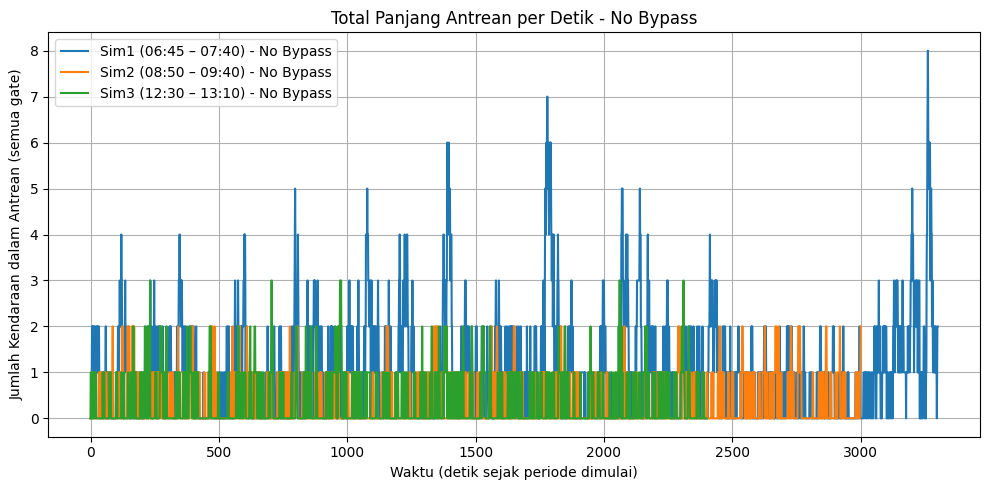

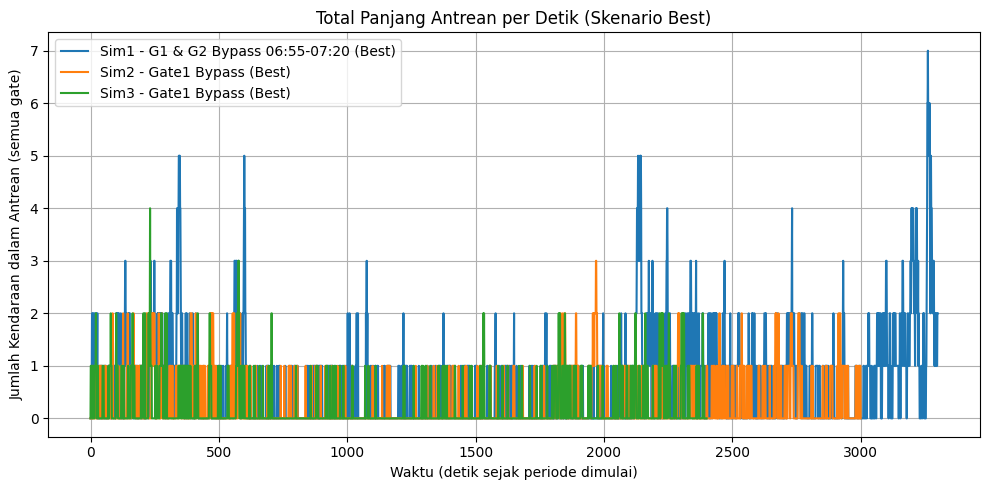

In [ ]:
# fungsi sum antrean di semua gate per detik
def total_queue_length(queue_len_history):
    # terima queue_len_history: dict {1: [...], 2: [...], 3: [...]}
    # return list total antrean (sum gate 1–3) untuk setiap t
    length = []
    sim_duration = len(next(iter(queue_len_history.values())))  # panjang list
    for t in range(sim_duration):
        total = queue_len_history[1][t] + queue_len_history[2][t] + queue_len_history[3][t]
        length.append(total)
    return length

# data untuk plot: compare ketiga periode untuk no bypass
times_nb = {}
queues_nb = {}
for sim_name in ["Sim1 06:45 - 07:40", "Sim2 08:50 - 09:40", "Sim3 12:30 - 13:10"]:
    data = all_results[sim_name]
    sim_duration = data["sim_duration"]
    # time axis: detik t = 0 sampai t = sim_duration
    times_nb[sim_name] = list(range(sim_duration + 1))
    # ambil queue_len_history untuk no bypass
    qlh = data["period_results"]["No Bypass"]["metrics"]["queue_len_history"]
    queues_nb[sim_name] = total_queue_length(qlh)

# plot perbandingan ketiga periode no bypass
plt.figure(figsize=(10, 5))
plt.plot(times_nb["Sim1 06:45 - 07:40"], queues_nb["Sim1 06:45 - 07:40"], label="Sim1 (06:45 – 07:40) - No Bypass")
plt.plot(times_nb["Sim2 08:50 - 09:40"], queues_nb["Sim2 08:50 - 09:40"], label="Sim2 (08:50 – 09:40) - No Bypass")
plt.plot(times_nb["Sim3 12:30 - 13:10"], queues_nb["Sim3 12:30 - 13:10"], label="Sim3 (12:30 – 13:10) - No Bypass")

plt.title("Total Panjang Antrean per Detik - No Bypass")
plt.xlabel("Waktu (detik sejak periode dimulai)")
plt.ylabel("Jumlah Kendaraan dalam Antrean (semua gate)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# bandingkan ketiga periode untuk skenario best
times_best = {}
queues_best = {}
for sim_name in ["Sim1 06:45 - 07:40", "Sim2 08:50 - 09:40", "Sim3 12:30 - 13:10"]:
    data = all_results[sim_name]
    sim_duration = data["sim_duration"]
    times_best[sim_name] = list(range(sim_duration + 1))
    scenario_best = best_scenarios[sim_name]
    qlh_best = data["period_results"][scenario_best]["metrics"]["queue_len_history"]
    queues_best[sim_name] = total_queue_length(qlh_best)

plt.figure(figsize=(10, 5))
plt.plot(times_best["Sim1 06:45 - 07:40"], queues_best["Sim1 06:45 - 07:40"], label=f"Sim1 - {best_scenarios['Sim1 06:45 - 07:40']} (Best)")
plt.plot(times_best["Sim2 08:50 - 09:40"], queues_best["Sim2 08:50 - 09:40"], label=f"Sim2 - {best_scenarios['Sim2 08:50 - 09:40']} (Best)")
plt.plot(times_best["Sim3 12:30 - 13:10"], queues_best["Sim3 12:30 - 13:10"], label=f"Sim3 - {best_scenarios['Sim3 12:30 - 13:10']} (Best)")

plt.title("Total Panjang Antrean per Detik (Skenario Best)")
plt.xlabel("Waktu (detik sejak periode dimulai)")
plt.ylabel("Jumlah Kendaraan dalam Antrean (semua gate)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


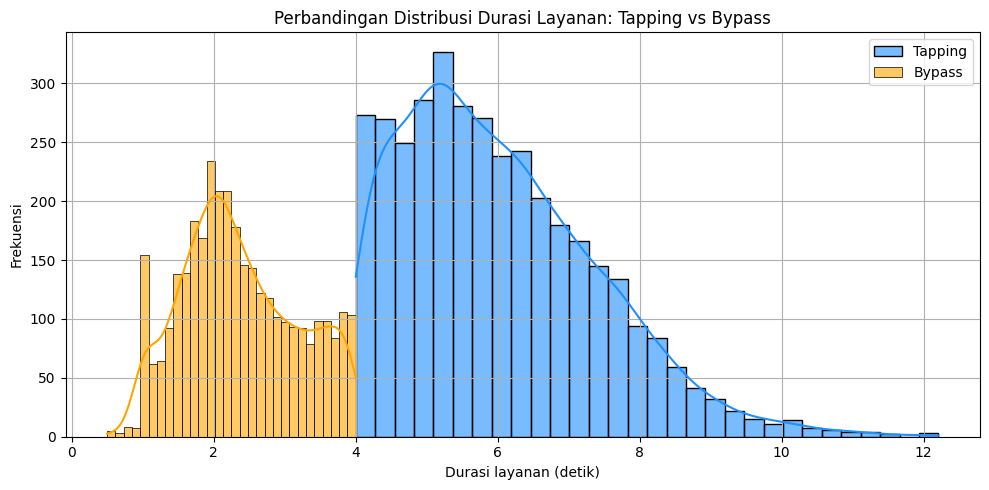

In [ ]:
import seaborn as sns

durasi_tapping = []
durasi_bypass = []

for sim_data in all_results.values():
    for scenario_data in sim_data['period_results'].values():
        for v in scenario_data['vehicles']:
            if v.service_start is not None and v.service_end is not None:
                dur = v.service_end - v.service_start
                # klasifikasi based on durasi (asumsi bypass lebih cepat dari tapping)
                if dur < 4:
                    durasi_bypass.append(dur)
                else:
                    durasi_tapping.append(dur)

plt.figure(figsize=(10, 5))
sns.histplot(durasi_tapping, bins=30, kde=True, label='Tapping', color='dodgerblue', alpha=0.6)
sns.histplot(durasi_bypass, bins=30, kde=True, label='Bypass', color='orange', alpha=0.6)
plt.title("Perbandingan Distribusi Durasi Layanan: Tapping vs Bypass")
plt.xlabel("Durasi layanan (detik)")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
